<a href="https://colab.research.google.com/github/rafajacomel/phd_ita/blob/main/olist_grade_logistic_regression_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspellchecker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from gensim.models import word2vec
from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import json
import requests
import xgboost as xgb
import itertools
import string
import re
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
file='/content/sample_data/movies_portuguese.csv'
df=pd.read_csv(file, encoding='utf-8')

In [6]:
df.head()

,text,label
0,Recebi bem antes do prazo estipulado.,1
1,Parabéns lojas lannister adorei comprar pela I...,1
2,aparelho eficiente. no site a marca do aparelh...,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
4,"Vendedor confiável, produto ok e entrega antes...",1


In [7]:
df['label'].value_counts()

1    25746
0    14113
Name: label, dtype: int64

In [8]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [9]:
X_train.head()

22801    superou minhas expectativas. \r\no produto che...
29480     recebi muitos dias antes da previsão. recomendo!
33543                                                otimo
11583    gostaria de saber o que houve. compro ha anos ...
25408    sempre satisfeita com aquisição de qq produto ...
Name: text, dtype: object

In [10]:
pattern = "[A-Za-zÀ-ÿ]+"
stopwords_list=stopwords.words('portuguese')
tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [11]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [12]:
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [13]:
tokenized_train.head()

22801    [superou, minhas, expectativas, o, produto, ch...
29480    [recebi, muitos, dias, antes, da, previsão, re...
33543                                              [otimo]
11583    [gostaria, de, saber, o, que, houve, compro, h...
25408    [sempre, satisfeita, com, aquisição, de, qq, p...
Name: text, dtype: object

In [14]:
ns_tk_train.head()

22801    [superou, expectativas, produto, chegou, dia, ...
29480    [recebi, muitos, dias, antes, previsão, recome...
33543                                              [otimo]
11583    [gostaria, saber, compro, ha, anos, lannister,...
25408    [sempre, satisfeita, aquisição, qq, produto, c...
Name: text, dtype: object

In [15]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [16]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [17]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [18]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

13037

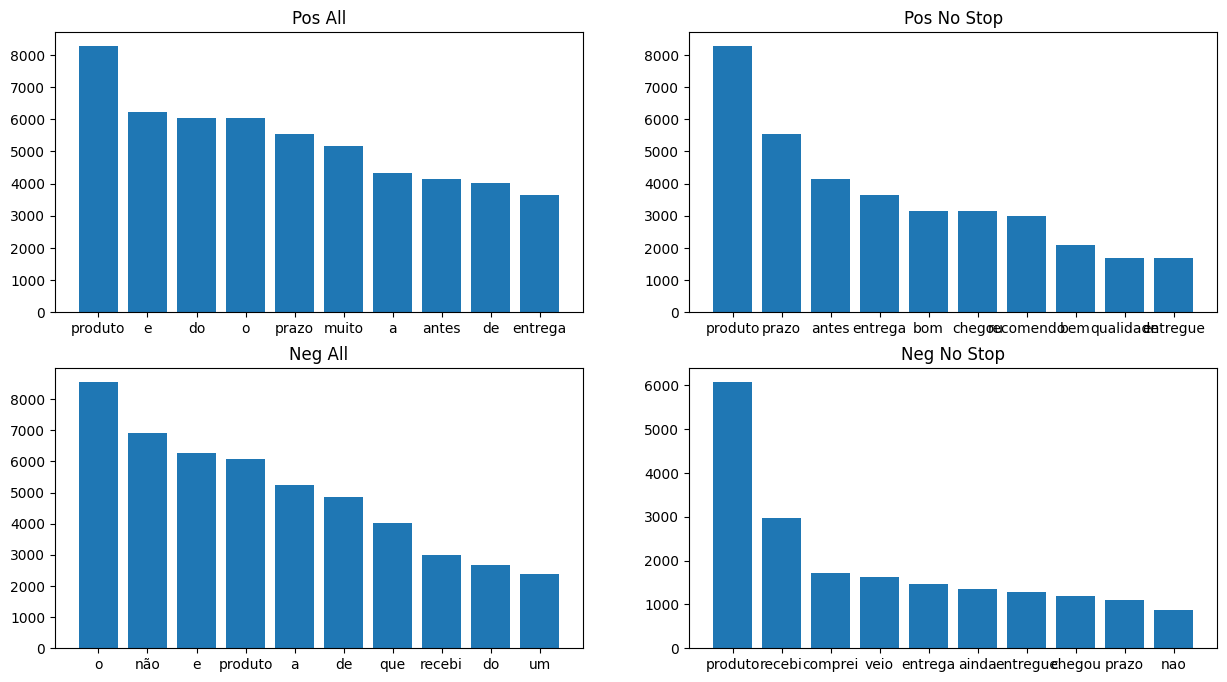

In [19]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])

In [20]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br
18629,"[bom, dia, gostaria, de, saber, porque, meu, p...","[bom, dia, gostaria, saber, porque, pedido, ve...",0,1
2461,"[o, produto, é, igual, a, oferta, porém, é, xi...","[produto, igual, oferta, porém, xing, ling, ve...",0,1
38142,"[rastreamento, pp, br, ainda, não, chegou, na,...","[rastreamento, pp, br, ainda, chegou, unidade,...",0,1
25404,"[produto, fiel, ao, anúncio, diferente, de, ou...","[produto, fiel, anúncio, diferente, outras, lo...",1,1
31923,"[chego, certo, adoro, comprar, na, lannister, ...","[chego, certo, adoro, comprar, lannister, br, ...",1,1


In [21]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

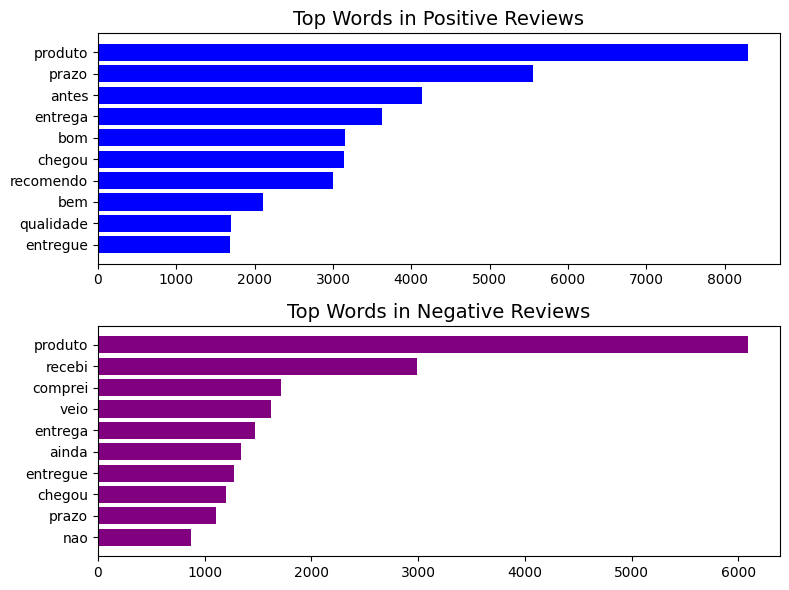

In [22]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(10)
neg_fd=FreqDist(neg['token'].explode()).most_common(10)
pos_fd.sort(key=lambda x: x[1])
neg_fd.sort(key=lambda x: x[1])

fig,axes=plt.subplots(2,figsize=(8,6))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]



axes[0].barh(pos_x,pos_y,color='blue')
axes[0].set_title('Top Words in Positive Reviews',fontsize=14)
axes[1].barh(neg_x,neg_y,color='purple')
axes[1].set_title('Top Words in Negative Reviews',fontsize=14)
plt.tight_layout()

In [23]:
stopwords_list=stopwords.words('english')
stopwords_list.append('br')
remove=['up','down','didn',"didn't",'wasn',"wasn't",'wouldn',"wouldn't"]
for word in remove:
    stopwords_list.remove(word)

stemmer=SnowballStemmer('english')
stopwords_stemmed=[]

for w in stopwords_list:
    stopwords_stemmed.append(stemmer.stem(w))

wnl=WordNetLemmatizer()
stopwords_lemmatized=[]

for w in stopwords_list:
    stopwords_lemmatized.append(wnl.lemmatize(w))

In [24]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [25]:
class W2vVectorizer(object):

    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])

    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [26]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    """
    Dummy class that allows us to modify only the methods that interest us,
    avoiding redudancy.
    """
    def __init__(self):
        return None

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None):
        return self

In [27]:
class Preprocess(DummyTransformer):

    def __init__(self,
                 stopwords_list=stopwords_list,
                 stopwords_stemmed=stopwords_stemmed,
                 stopwords_lemmatized=stopwords_lemmatized,
                 vector='count',
                 stemming=None,
                 spell_check=False,
                n_grams=(1,1),
                max_df=1.0,
                 max_feat=None,
                chi_percent=None,
                y=None):
        #defines how the text will be preprocessed

        self.stopwords_list=stopwords_list
        self.stopwords_stemmed=stopwords_stemmed
        self.stopwords_lemmatized=stopwords_lemmatized
        self.vector = vector
        #can be 'count','tfidf',or 'embedding'
        self.stemming=stemming
        #can be 'None','stem','lemmatize'
        self.spell_check=spell_check
        #True or False
        self.n_grams=n_grams
        #n_gram to pass to tokenizer like (1,1) or (1,2)
        self.max_df=max_df
        #positive float less than or equal to 1.0, to pass to vectorizer
        self.max_features=max_feat
        self.chi_percent=chi_percent
        self.y=y
        #positive integer less than 100, percent features to keep if filtering with chi2
        #None if no filtering
        #self.glove_file_=glove_file
        #None if using count or tfidf, glove file for word embeddings


    def tokenize(self,text):
        pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
        tokenizer=RegexpTokenizer(pattern)
        tokens=tokenizer.tokenize(text)

        if self.spell_check==True:
            tokens=correct_spelling(tokens)

        if self.stemming=='lemmatize':

            wnl=WordNetLemmatizer()

            stems = []

            for item in tokens:
                stems.append(wnl.lemmatize(item))

        elif self.stemming=='stem':
            stems=[]
            stemmer=SnowballStemmer('portuguese')

            for item in tokens:
                stems.append(stemmer.stem(item))

        else:
            stems=tokens
        return stems

    def filter_words_by_count(self,X,tokenized):

        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2

        vectorizer=CountVectorizer(stop_words=sw[idx],
                                   max_df=self.max_df,
                                   min_df=5)
        vectorizer.fit(X)

        #filter out words
        words_to_keep=vectorizer.vocabulary_.keys()
        filtered_data=tokenized.apply(lambda tok: [w for w in tok if w in words_to_keep])

        return filtered_data

    def build_glove(self,tokens):
        total_vocab=set([word for review in tokens for word in review])
        glove = {}
        #count=0
        #words=[]
        with open('glove_english.6B.300d.txt', 'rb') as f:
            for line in f:
                parts = line.split()
                word = parts[0].decode('utf-8')
                if word in total_vocab:
                    vector = np.array(parts[1:], dtype=np.float32)
                    glove[word] = vector
                    #count+=1
                    #words.append(word)
        return glove

    def transform(self, X):

        #tokenize according to inputs
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2

        if self.vector=='count':

            vectorizer=CountVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()

        elif self.vector=='tfidf':

            vectorizer=TfidfVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()

        elif self.vector=='embedding':
            tokenized=X.apply(self.tokenize)
            filtered=self.filter_words_by_count(X,tokenized)
            glove=self.build_glove(filtered)
            w2v=W2vVectorizer(glove)
            tokens=w2v.transform(filtered)

        if (self.chi_percent != None) and (self.vector != 'embedding'):

            selector=SelectPercentile(chi2,percentile=self.chi_percent)
            selected=selector.fit_transform(tokens,self.y)
            tokens=selected
        #print('finished')
        return tokens


In [28]:
def preprocess_grid(X_train,y_train,vector_type,params_lists):
    combos=list(itertools.product(*params_lists))
    print(len(combos))
    tokenized=[]
    count=0
    for c in combos:
        pp=Preprocess(stopwords_list=stopwords_list,
                      vector=vector_type,
                     stemming=c[0],
                     spell_check=c[1],
                    n_grams=c[2],
                    max_df=c[3],
                    chi_percent=c[4],
                      max_feat=10000,
                    y=y_train)
        tokens=pp.transform(X_train)
        tokenized.append((c,tokens))
        count+=1
        #print(count)
    return tokenized

In [29]:
def pipeline_nlp(estimator,vector_type,X_train,y_train,params_lists):
    #returns results from cross validation

    tokenized = preprocess_grid(X_train,y_train,vector_type,params_lists)
    results=[]

    count=0

    for features, xtrain in tokenized:
        result=cross_val_score(estimator,xtrain,y_train,cv=3)
        results.append((features,result.mean()))
        count+=1
        #print(count)

    return pd.DataFrame(results)

In [30]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=5000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

logreg=LogisticRegression(max_iter=500)

logreg.fit(tokens_train,y_train)
results=cross_val_score(logreg,tokens_train,y_train)
print(results)
results.mean()

[0.89024773 0.89165883 0.89164184 0.89415085 0.89571899]


0.8926836472775983

In [31]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,1),(1,2)],
      [.2,.5,.7],
      [10]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'count',X_train,y_train,params_lists)
logreg_results=result_df.sort_values(by=1,ascending=False)
logreg_results

12


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr

,0,1
4,"(None, False, (1, 2), 0.5, 10)",0.891962
5,"(None, False, (1, 2), 0.7, 10)",0.891962
10,"(stem, False, (1, 2), 0.5, 10)",0.891617
11,"(stem, False, (1, 2), 0.7, 10)",0.891617
9,"(stem, False, (1, 2), 0.2, 10)",0.891053
3,"(None, False, (1, 2), 0.2, 10)",0.889202
1,"(None, False, (1, 1), 0.5, 10)",0.883777
2,"(None, False, (1, 1), 0.7, 10)",0.883777
7,"(stem, False, (1, 1), 0.5, 10)",0.879982
8,"(stem, False, (1, 1), 0.7, 10)",0.879982


In [32]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem','lemmatize'],
      [False],
      [(1,2)],
      [.7],
      [8,10,12]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'count',X_train,y_train,params_lists)
logreg_results=pd.concat([logreg_results,result_df]).sort_values(by=1,ascending=False)
logreg_results

6


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dur', 'furth', 'hav', 'mor', 'sam', 'som', 'ther', 'thes', 'thos', 'ver', 'wer', 'wher', 'whil'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dur', 'furth', 'hav', 'mor', 'sam', 'som', 'ther', 'thes', 'thos', 'ver', 'wer', 'wher', 'whi

,0,1
5,"(lemmatize, False, (1, 2), 0.7, 12)",0.892934
5,"(None, False, (1, 2), 0.7, 10)",0.891962
4,"(None, False, (1, 2), 0.5, 10)",0.891962
4,"(lemmatize, False, (1, 2), 0.7, 10)",0.891774
2,"(stem, False, (1, 2), 0.7, 12)",0.891649
11,"(stem, False, (1, 2), 0.7, 10)",0.891617
10,"(stem, False, (1, 2), 0.5, 10)",0.891617
1,"(stem, False, (1, 2), 0.7, 10)",0.891617
9,"(stem, False, (1, 2), 0.2, 10)",0.891053
0,"(stem, False, (1, 2), 0.7, 8)",0.890237


In [33]:
logreg_results.to_csv('lr_count_results.csv')

In [34]:
print(logreg_results)

                                      0         1
5   (lemmatize, False, (1, 2), 0.7, 12)  0.892934
5        (None, False, (1, 2), 0.7, 10)  0.891962
4        (None, False, (1, 2), 0.5, 10)  0.891962
4   (lemmatize, False, (1, 2), 0.7, 10)  0.891774
2        (stem, False, (1, 2), 0.7, 12)  0.891649
11       (stem, False, (1, 2), 0.7, 10)  0.891617
10       (stem, False, (1, 2), 0.5, 10)  0.891617
1        (stem, False, (1, 2), 0.7, 10)  0.891617
9        (stem, False, (1, 2), 0.2, 10)  0.891053
0         (stem, False, (1, 2), 0.7, 8)  0.890237
3    (lemmatize, False, (1, 2), 0.7, 8)  0.890143
3        (None, False, (1, 2), 0.2, 10)  0.889202
1        (None, False, (1, 1), 0.5, 10)  0.883777
2        (None, False, (1, 1), 0.7, 10)  0.883777
7        (stem, False, (1, 1), 0.5, 10)  0.879982
8        (stem, False, (1, 1), 0.7, 10)  0.879982
0        (None, False, (1, 1), 0.2, 10)  0.866999
6        (stem, False, (1, 1), 0.2, 10)  0.866058


In [35]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem','lemmatize'],
      [False],
      [(1,2)],
      [.3,.5,.7],
      [10]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'tfidf',X_train,y_train,params_lists)
lr_tfidf_results=result_df.sort_values(by=1,ascending=False)
lr_tfidf_results

9


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dur', 'furth', 'hav', 'mor', 'sam', 'som', 'ther'

,0,1
4,"(stem, False, (1, 2), 0.5, 10)",0.893656
5,"(stem, False, (1, 2), 0.7, 10)",0.893656
3,"(stem, False, (1, 2), 0.3, 10)",0.893624
6,"(lemmatize, False, (1, 2), 0.3, 10)",0.892213
7,"(lemmatize, False, (1, 2), 0.5, 10)",0.892088
8,"(lemmatize, False, (1, 2), 0.7, 10)",0.892088
0,"(None, False, (1, 2), 0.3, 10)",0.891555
1,"(None, False, (1, 2), 0.5, 10)",0.891492
2,"(None, False, (1, 2), 0.7, 10)",0.891492


In [36]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.4,.6],
      [70,80]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'tfidf',X_train,y_train,params_lists)
lr_tfidf_results=pd.concat([lr_tfidf_results,result_df]).sort_values(by=1,ascending=False)
lr_tfidf_results

4


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,0,1
2,"(None, False, (1, 2), 0.6, 70)",0.898987
0,"(None, False, (1, 2), 0.4, 70)",0.898799
3,"(None, False, (1, 2), 0.6, 80)",0.898391
1,"(None, False, (1, 2), 0.4, 80)",0.898234
4,"(stem, False, (1, 2), 0.5, 10)",0.893656
5,"(stem, False, (1, 2), 0.7, 10)",0.893656
3,"(stem, False, (1, 2), 0.3, 10)",0.893624
6,"(lemmatize, False, (1, 2), 0.3, 10)",0.892213
7,"(lemmatize, False, (1, 2), 0.5, 10)",0.892088
8,"(lemmatize, False, (1, 2), 0.7, 10)",0.892088


In [37]:
lr_tfidf_results.to_csv('lr_tfidf_results.csv')

In [38]:
#Grid search logreg hyperparameters w/best preprocessing

order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized=preprocess_grid(X_train,y_train,'tfidf',params_lists)
X_train_pp=tokenized[0][1]

logreg=LogisticRegression()

params={
    'penalty': ['l1','l2','elasticnet'],
    'C': [.1,1,10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

lr_gs=GridSearchCV(logreg,cv=3,param_grid=params,verbose=2,scoring='accuracy')
results=lr_gs.fit(X_train_pp,y_train)


1


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   1.7s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   1.5s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   1.6s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   1.5s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   1.6s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   1.5s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time= 2.3min
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  35.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time= 2.3min
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=  11.3s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=  10.4s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=  11.6s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   4.9s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   5.3s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   5.3s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  21.7s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  25.9s
[CV] END ...................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time= 2.5min
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=  16.5s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=  16.9s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=  16.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   9.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   7.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   7.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=  24.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=  23.1s
[CV] END ...................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time= 2.4min
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=  25.5s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=  26.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=  24.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=  12.7s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=10, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=10, penalty=l2, solver=saga; total time= 1.2min
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   1.6s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   1.8s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   1.6s
[CV] END .............C=10, penalty=elasticnet, solver=lbfgs; total time=   1.6s
[CV] END .............C=10, penalty=elasticnet, solver=lbfgs; total time=   1.6s
[CV] END .............C=10, 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [39]:
print(results.best_params_)
print(results.best_score_)

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8986107191018284


In [40]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['saga'],
    'max_iter': [1000]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.8995515413804999


In [41]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['saga'],
    'max_iter': [2000]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
0.8995515413804999


In [42]:
params={
    'penalty': ['elasticnet'],
    'C': [5,10,15],
    'solver': ['saga'],
    'max_iter': [1000],
    'l1_ratio': [.3,.5]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'l1_ratio': 0.3, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
0.8987361620723179


In [43]:
X_train_pp.shape

(31887, 6000)

In [44]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized=preprocess_grid(X_train,y_train,'tfidf',params_lists)
X_train_pp=tokenized[0][1]

1


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
pca=PCA()
transformed=pca.fit_transform(X_train_pp)

In [46]:
transformed.shape

(31887, 6000)

In [47]:
np.cumsum(pca.explained_variance_ratio_)[4000]

0.9745090870026394

In [48]:
X_train_pca=transformed[:,:4000]

In [49]:
X_train_pca.shape

(31887, 4000)

In [50]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['liblinear','lbfgs','newton-cg'],
    'max_iter': [1000]
}

logreg=LogisticRegression()

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pca,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8988616050428074


In [52]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,2)],
      [.6],
      [None]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'embedding',X_train,y_train,params_lists)
lr_mwe_results=result_df.sort_values(by=1,ascending=False)
lr_mwe_results

2


FileNotFoundError: ignored

In [53]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,1)],
      [.3,.5,.8],
      [None]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'embedding',X_train,y_train,params_lists)
lr_mwe_results=pd.concat([lr_mwe_results,result_df]).sort_values(by=1,ascending=False)
lr_mwe_results

3


FileNotFoundError: ignored

In [54]:
#Define final pipeline with chosen preprocessing steps and model

#takes in raw movie reviews

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

final_vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                       max_features=20000,
                                       token_pattern=pattern,
                                       ngram_range=(1,2),
                                       min_df=5,
                                       max_df=.6
                                      )

final_selector = SelectPercentile(chi2,percentile=60)

final_model=LogisticRegression(max_iter=1000,
                               C=5,
                               penalty='l2',
                               solver='saga')

final_pipeline=Pipeline(steps=[
    ('vectorizer',final_vectorizer),
    ('selector',final_selector),
    ('model',final_model)])


In [55]:
cross_val_score(final_pipeline,X_train,y_train)

array([0.89683286, 0.89714644, 0.90199153, 0.89775757, 0.90261879])

In [56]:
final_pipeline.fit(X_train,y_train)

final_pipeline.score(X_test,y_test)

0.897767185148018

In [57]:
#use roc AUC
y_hat_prob=final_pipeline.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_hat_prob)
print('roc-auc for the final model is: {}'.format(roc_auc))

roc-auc for the final model is: 0.9523138978718326


In [58]:
plot_confusion_matrix(final_pipeline,X_test,y_test)

NameError: ignored

In [59]:
y_hat=final_pipeline.predict(X_test)
classification_report(y_test,y_hat,output_dict=True)

{'0': {'precision': 0.857245337159254,
  'recall': 0.8514428215176345,
  'f1-score': 0.8543342269883826,
  'support': 2807},
 '1': {'precision': 0.9195601851851852,
  'recall': 0.9229428848015488,
  'f1-score': 0.9212484297999808,
  'support': 5165},
 'accuracy': 0.897767185148018,
 'macro avg': {'precision': 0.8884027611722196,
  'recall': 0.8871928531595916,
  'f1-score': 0.8877913283941816,
  'support': 7972},
 'weighted avg': {'precision': 0.897618667572442,
  'recall': 0.897767185148018,
  'f1-score': 0.8976874454432127,
  'support': 7972}}

In [60]:
logreg_coef=final_pipeline.get_params()['model'].coef_[0]

In [ ]:
len(logreg_coef)

In [62]:
logreg_coef

array([ 0.76745423,  0.72995193, -1.5335855 , ...,  0.04964037,
       -2.48855555, -0.06543573])

In [63]:
#get dictionary of vocab and indices that were included in output

tfidf_mapping=final_pipeline.get_params()['vectorizer'].vocabulary_

In [64]:
tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_map[:10]

[('superou', 9995),
 ('minhas', 6189),
 ('expectativas', 4447),
 ('produto', 8312),
 ('chegou', 1250),
 ('dia', 2903),
 ('depois', 2739),
 ('que', 8755),
 ('comprei', 1800),
 ('sendo', 9701)]

In [65]:
tfidf_map.sort(key=lambda x: x[1])

In [66]:
tfidf_map[:5]

[('abaixo', 0), ('abajur', 1), ('aben', 2), ('aben oe', 3), ('aberta', 4)]

In [67]:
vocab_tfidf=[x[0] for x in tfidf_map]
vocab_tfidf[:10]

['abaixo',
 'abajur',
 'aben',
 'aben oe',
 'aberta',
 'aberta e',
 'aberto',
 'aberto e',
 'abra',
 'abra os']

In [68]:
fitted_sel=final_pipeline.get_params()['selector']
fitted_sel

SelectPercentile(percentile=60, score_func=<function chi2 at 0x7f84435d31c0>)

In [69]:
#get boolean mask of which features were selected by SelectPercentile
mask=fitted_sel.get_support()

In [70]:
mask

array([False, False,  True, ...,  True,  True,  True])

In [71]:
final_vocab=np.array(vocab_tfidf)[mask]

In [72]:
len(final_vocab)

6665

In [73]:
coef_df=pd.DataFrame(list(zip(final_vocab,logreg_coef)),columns=['word','coef'])
coef_df.head()

,word,coef
0,aben,0.767454
1,aben oe,0.729952
2,aberta,-1.533585
3,aberta e,-1.270588
4,aberto,-0.828885


In [74]:
coef_df.sort_values(by='coef',ascending=False).head()

,word,coef
63,adorei,5.745636
3303,lindo,5.536453
4506,perfeito,5.486209
205,amei,5.448369
2590,excelente,4.873726


In [75]:
coef_df.sort_values(by='coef',ascending=False).tail()

,word,coef
4236,p ssima,-4.775716
3945,nao,-4.796459
3861,n recebi,-5.449706
3866,n recomendo,-7.149626
3750,n,-7.803597


In [76]:
coef_list=list(zip(final_vocab,logreg_coef))
coef_dict={x[0]: x[1] for x in coef_list}

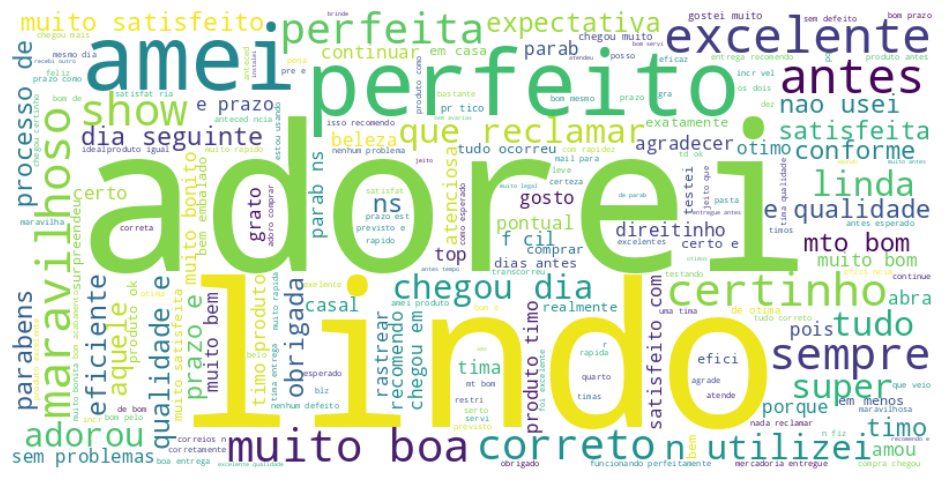

In [77]:
#plot word cloud for positive review classification
wordcloud=WordCloud(width=800,height=400,background_color='white')

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()
#wordcloud.to_file('pos_feature_importance.png')

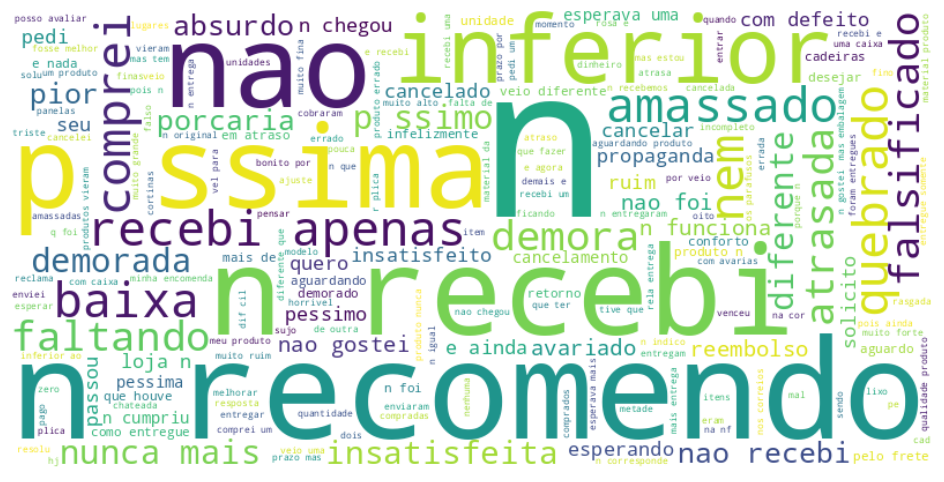

In [78]:
#plot word cloud for features contributing to negative review classification

coef_list=list(zip(final_vocab,logreg_coef*-1))
coef_dict={x[0]: x[1] for x in coef_list}

wordcloud=WordCloud(width=800,height=400,background_color='white')

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()
#wordcloud.to_file('neg_feature_importance.png')